In [1]:
import keras
import glob
import seaborn as sns
import pandas as pd
import numpy as np
import timeit
import time
import matplotlib.pyplot as plt
import matplotlib.patches as patches

Using TensorFlow backend.


In [2]:
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

In [3]:
cross1=pd.read_csv('oasis_longitudinal.csv')
cross1 = cross1.fillna(method='ffill')
cross2=pd.read_csv('oasis_cross-sectional.csv')
cross2 = cross2.fillna(method='ffill')
print (cross1.head())
print (cross2.head())
print (cross1.info())
print (cross2.info())

  Subject ID         MRI ID        Group  Visit  MR Delay M/F Hand  Age  EDUC  \
0  OAS2_0001  OAS2_0001_MR1  Nondemented      1         0   M    R   87    14   
1  OAS2_0001  OAS2_0001_MR2  Nondemented      2       457   M    R   88    14   
2  OAS2_0002  OAS2_0002_MR1     Demented      1         0   M    R   75    12   
3  OAS2_0002  OAS2_0002_MR2     Demented      2       560   M    R   76    12   
4  OAS2_0002  OAS2_0002_MR3     Demented      3      1895   M    R   80    12   

   SES  MMSE  CDR  eTIV   nWBV    ASF  
0  2.0  27.0  0.0  1987  0.696  0.883  
1  2.0  30.0  0.0  2004  0.681  0.876  
2  2.0  23.0  0.5  1678  0.736  1.046  
3  2.0  28.0  0.5  1738  0.713  1.010  
4  2.0  22.0  0.5  1698  0.701  1.034  
              ID M/F Hand  Age  Educ  SES  MMSE  CDR  eTIV   nWBV    ASF  \
0  OAS1_0001_MR1   F    R   74   2.0  3.0  29.0  0.0  1344  0.743  1.306   
1  OAS1_0002_MR1   F    R   55   4.0  1.0  29.0  0.0  1147  0.810  1.531   
2  OAS1_0003_MR1   F    R   73   4.0  3.0  27

             Visit  MR Delay       Age      EDUC       SES      MMSE  \
Visit     1.000000  0.920009  0.183213  0.024615 -0.040956 -0.030325   
MR Delay  0.920009  1.000000  0.205357  0.051630 -0.028744  0.065058   
Age       0.183213  0.205357  1.000000 -0.027886 -0.042893  0.055848   
EDUC      0.024615  0.051630 -0.027886  1.000000 -0.671277  0.196159   
SES      -0.040956 -0.028744 -0.042893 -0.671277  1.000000 -0.130272   
MMSE     -0.030325  0.065058  0.055848  0.196159 -0.130272  1.000000   
CDR       0.002325 -0.062915 -0.026257 -0.153121  0.069921 -0.683312   
eTIV      0.117428  0.119624  0.042348  0.257015 -0.243555 -0.028163   
nWBV     -0.126682 -0.105586 -0.518359 -0.012200  0.096337  0.341315   
ASF      -0.120399 -0.123545 -0.035067 -0.241752  0.230536  0.035034   

               CDR      eTIV      nWBV       ASF  
Visit     0.002325  0.117428 -0.126682 -0.120399  
MR Delay -0.062915  0.119624 -0.105586 -0.123545  
Age      -0.026257  0.042348 -0.518359 -0.035067  
EDU

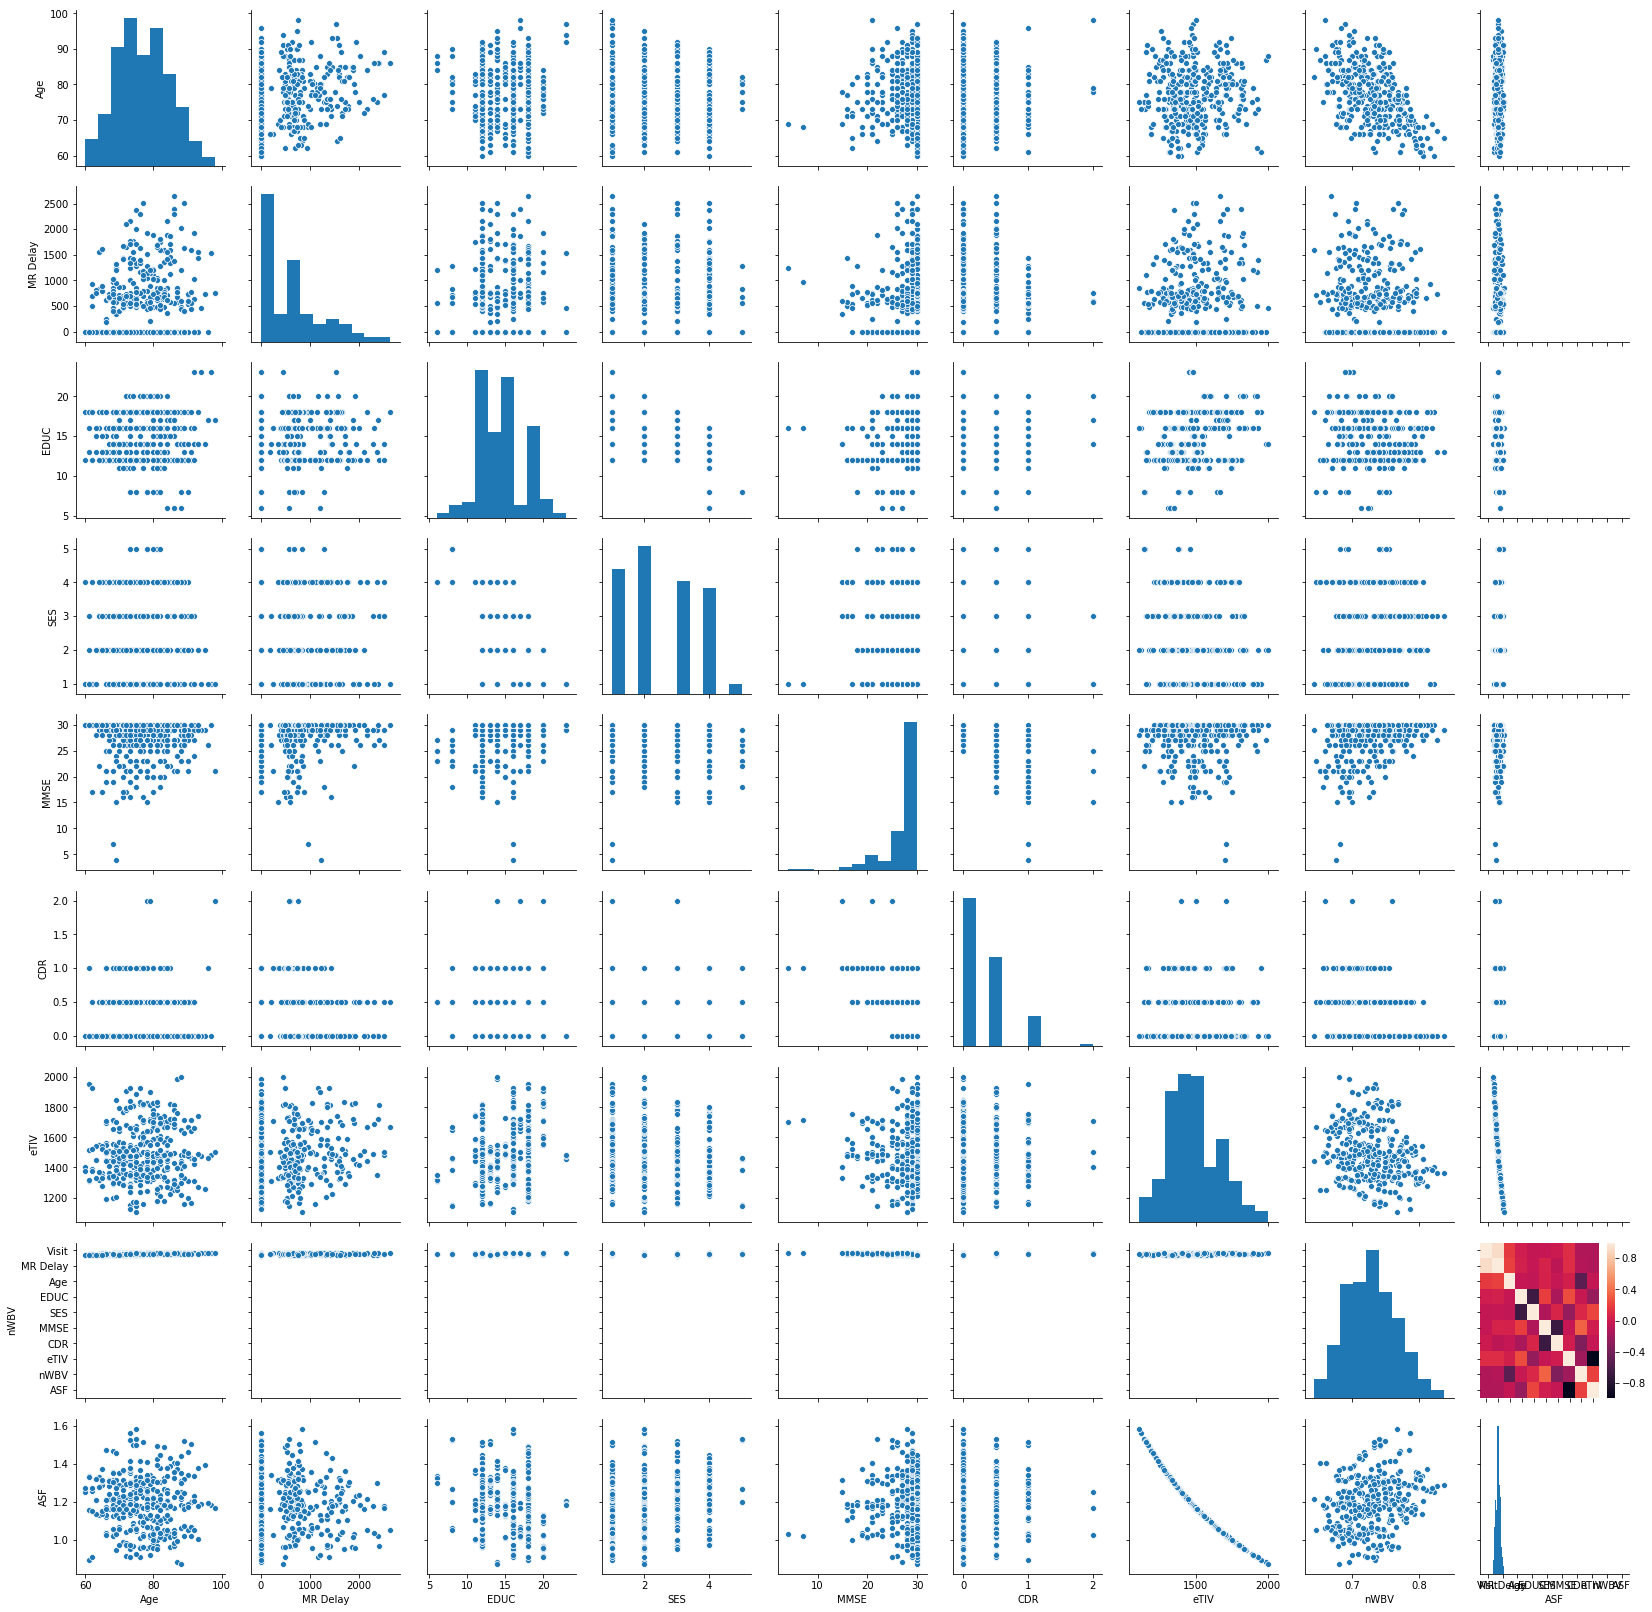

In [4]:
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5
cols = ['Age','MR Delay', 'EDUC', 'SES', 'MMSE', 'CDR','eTIV','nWBV','ASF']
x=cross1.fillna('')
sns_plot = sns.pairplot(x[cols])
corr_matrix =cross1.corr()
print (corr_matrix)
rcParams['figure.figsize'] = 15, 10
print (sns.heatmap(corr_matrix))
cross1['CDR'].replace(to_replace=0.0, value='A', inplace=True)
cross1['CDR'].replace(to_replace=0.5, value='B', inplace=True)
cross1['CDR'].replace(to_replace=1.0, value='C', inplace=True)
cross1['CDR'].replace(to_replace=2.0, value='D', inplace=True)

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
for x in cross1.columns:
    f = LabelEncoder()
    cross1[x] = f.fit_transform(cross1[x])
print (cross1.head())
train, test = train_test_split(cross1, test_size=0.3)
X_train = train[['M/F', 'Age', 'EDUC', 'SES', 'eTIV', 'ASF']]
y_train = train.CDR
#print(y_train)
X_test = test[['M/F', 'Age', 'EDUC', 'SES', 'eTIV', 'ASF']]
y_test = test.CDR

   Subject ID  MRI ID  Group  Visit  MR Delay  M/F  Hand  Age  EDUC  SES  \
0           0       0      2      0         0    1     0   27     5    1   
1           0       1      2      1        15    1     0   28     5    1   
2           1       2      1      0         0    1     0   15     3    1   
3           1       3      1      1        32    1     0   16     3    1   
4           1       4      1      2       185    1     0   20     3    1   

   MMSE  CDR  eTIV  nWBV  ASF  
0    14    0   284    35    1  
1    17    0   285    20    0  
2    10    1   231    73   52  
3    15    1   254    51   32  
4     9    1   238    40   46  


In [6]:
from sklearn.preprocessing import StandardScaler
# Define the scaler
scaler = StandardScaler().fit(X_train)
# Scale the train set
X_train = scaler.transform(X_train)
# Scale the test set
X_test = scaler.transform(X_test)
y_train=np.ravel(y_train)
X_train=np.asarray(X_train)
y_test=np.ravel(y_test)
X_test=np.asarray(X_test)

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\user\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  """
c:\users\user\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  import sys


c:\users\user\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\user\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Test score:  0.625
Train score:  0.6053639846743295


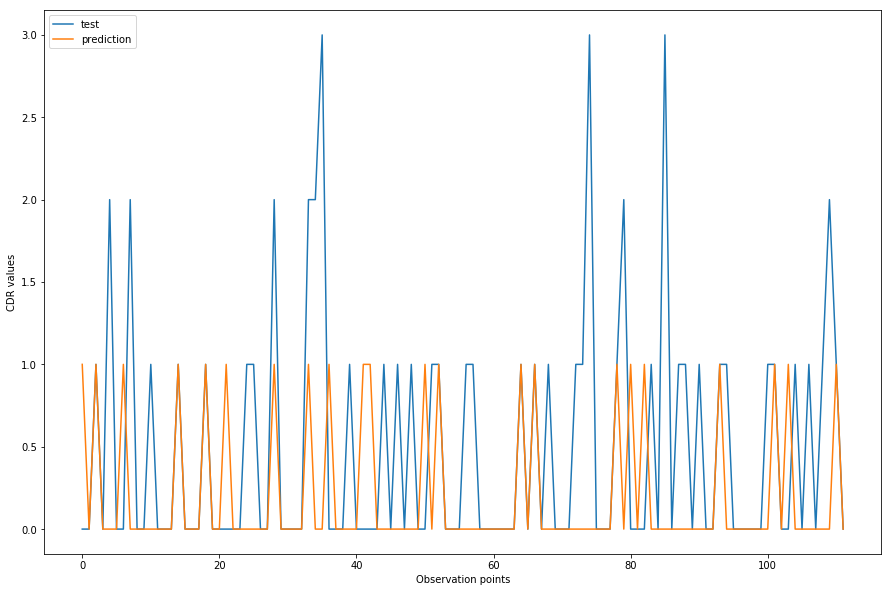

In [7]:
from sklearn.linear_model import LogisticRegression
classifier_tr = LogisticRegression()
classifier_tr.fit(X_train, y_train)
prediction_te = classifier_tr.predict(X_test)
a = classifier_tr.score(X_test, y_test)
b = classifier_tr.score(X_train, y_train)
print("Test score: ",a)
print("Train score: ",b)
#print(X_train)
#print(y_train.size)
a = []
for i in range(0, prediction_te.size):
    a.append(i)
plt.plot(a, y_test)
plt.plot(a, prediction_te)
plt.xlabel('Observation points')
plt.ylabel('CDR values')
plt.legend(['test', 'prediction'], loc='upper left')
plt.show()

Train score:  0.9616858237547893
Test score:  0.6428571428571429


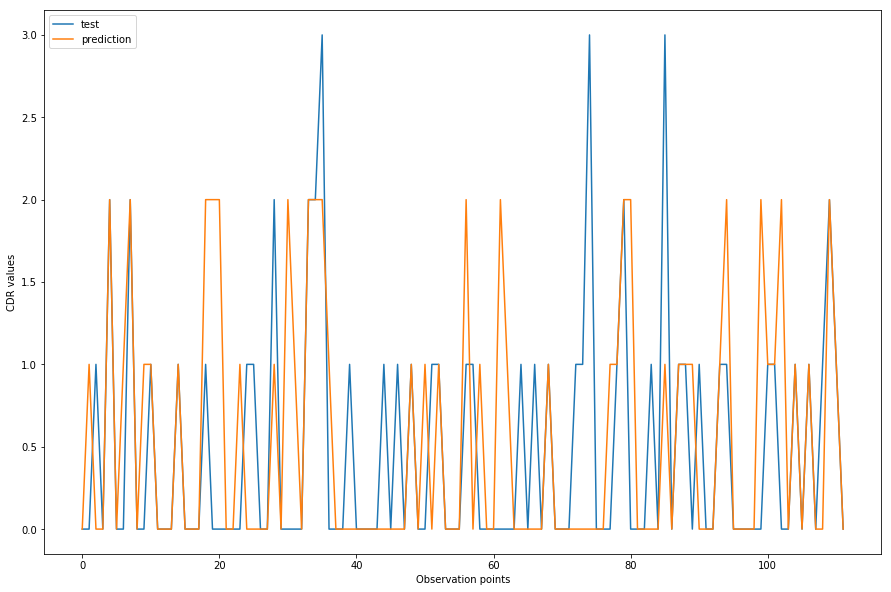

In [8]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(max_depth=12)
classifier.fit(X_train, y_train)
prediction = classifier.predict(X_test)
#print(y_test.size)
#print(prediction.size)
print ("Train score: ",classifier.score(X_train, y_train))
print ("Test score: ",classifier.score(X_test, y_test))
plt.plot(a, y_test)
plt.plot(a, prediction)
plt.xlabel('Observation points')
plt.ylabel('CDR values')
plt.legend(['test', 'prediction'], loc='upper left')
plt.show()

Train score:  0.8505747126436781
Test score:  0.6875


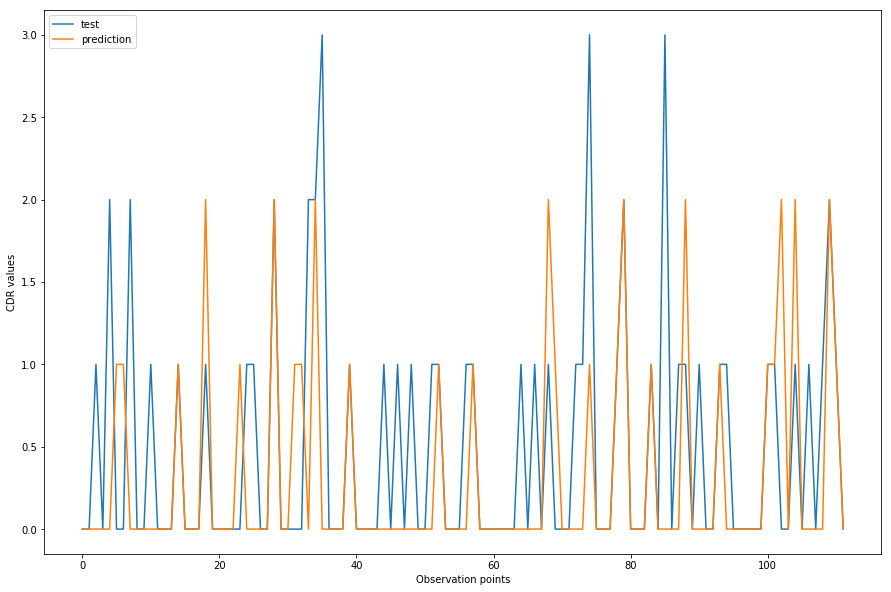

In [9]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
print("Train score: ",knn.score(X_train, y_train))
prediction = knn.predict(X_test)
print("Test score: ",knn.score(X_test, y_test))
plt.plot(a, y_test)
plt.plot(a, prediction)
plt.xlabel('Observation points')
plt.ylabel('CDR values')
plt.legend(['test', 'prediction'], loc='upper left')
plt.show()

Training score:  0.5325670498084292
Test score:  0.625
(261, 6)


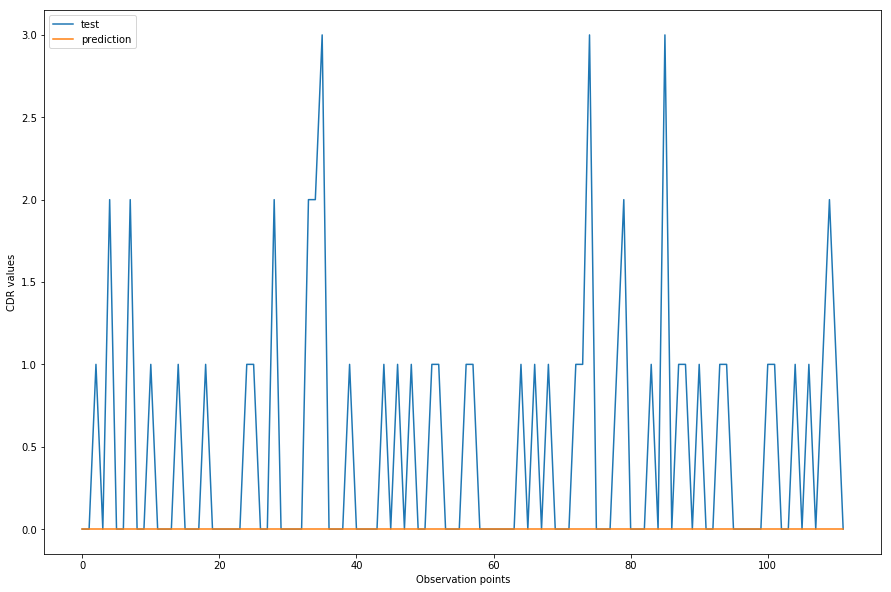

In [10]:
from sklearn.svm import SVC
svc=SVC(kernel="linear", C=0.01)
svc.fit(X_train, y_train)
prediction = svc.predict(X_test)
print("Training score: ",svc.score(X_train, y_train))
print("Test score: ",svc.score(X_test, y_test))
print (X_train.shape)
plt.plot(a, y_test)
plt.plot(a, prediction)
plt.xlabel('Observation points')
plt.ylabel('CDR values')
plt.legend(['test', 'prediction'], loc='upper left')
plt.show()

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\USER\\AppData\\Local\\Temp\\tmpftzms7cu', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000000048962EE10>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for upd

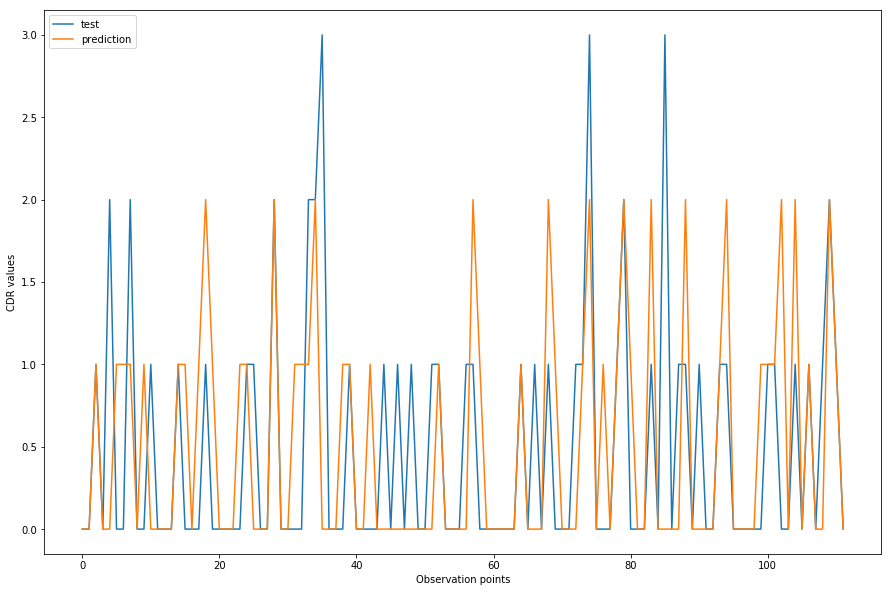

Accuracy (sklearn): 0.625000
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-03-09-03:37:41
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\USER\AppData\Local\Temp\tmpftzms7cu\model.ckpt-204
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-03-09-03:37:42
INFO:tensorflow:Saving dict for global step 204: accuracy = 0.625, average_loss = 1.2993813, global_step = 204, loss = 145.5307
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 204: C:\Users\USER\AppData\Local\Temp\tmpftzms7cu\model.ckpt-204
Accuracy (tensorflow): 0.625000
   Subject ID  MRI ID  Group  Visit  MR Delay  M/F  Hand  Age  EDUC  SES  \
0           0       0      2      0         0    1     0   27     5    1   
1           0       1      2      1        15    1     0   28     5    1   
2           1       2      1      0     

In [11]:
import tensorflow as tf
from sklearn import metrics
X_FEATURE = 'x' # Name of the input feature.
feature_columns = [
tf.feature_column.numeric_column(
X_FEATURE, shape=np.array(X_train).shape[1:])]
classifier = tf.estimator.DNNClassifier(feature_columns=feature_columns,
hidden_units=[35,70, 35], n_classes=4)
# Train.
train_input_fn = tf.estimator.inputs.numpy_input_fn(x={X_FEATURE: X_train}, y=y_train,
num_epochs=100, shuffle=False)
classifier.train(input_fn=train_input_fn, steps=1000)
print(train_input_fn)
# Predict.
test_input_fn = tf.estimator.inputs.numpy_input_fn(x={X_FEATURE: X_test}, y=y_test,
num_epochs=1, shuffle=False)
predictions = classifier.predict(input_fn=test_input_fn)
y_predicted = np.array(list(p['class_ids'] for p in predictions))
y_predicted = y_predicted.reshape(np.array(y_test).shape)
#print(test_input_fn)
plt.plot(a, y_test)
plt.plot(a, y_predicted)
plt.xlabel('Observation points')
plt.ylabel('CDR values')
plt.legend(['test', 'prediction'], loc='upper left')
plt.show()
# Score with sklearn.
score = metrics.accuracy_score(y_test, y_predicted)

print('Accuracy (sklearn): {0:f}'.format(score))
# Score with tensorflow.
scores = classifier.evaluate(input_fn=test_input_fn)
print('Accuracy (tensorflow): {0:f}'.format(scores['accuracy']))
#if __name__ == '__main__':
y_train
print(cross1.head())
print (cross2.head())
#print(scores['accuracy'])
#print(train_input_fn.history.keys())


In [12]:
for x in cross2.columns:
    f = LabelEncoder()
    cross2[x] = f.fit_transform(cross2[x])
df = pd.concat([cross1,cross2])
df = df.fillna(method='ffill')
print(df.head())
train, test = train_test_split(cross1, test_size=0.3)
X_train1 = train[['ASF', 'Age', 'EDUC', 'Group', 'Hand', 'M/F','MMSE','MR Delay','SES','eTIV','nWBV']]
y_train1 = train.CDR
X_test1 = test[['ASF', 'Age', 'EDUC', 'Group', 'Hand', 'M/F','MMSE','MR Delay','SES','eTIV','nWBV']]
y_test1 = test.CDR

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


   ASF  Age  CDR  Delay  EDUC  Educ  Group  Hand  ID  M/F  MMSE  MR Delay  \
0    1   27    0    NaN   5.0   NaN    2.0     0 NaN    1    14       0.0   
1    0   28    0    NaN   5.0   NaN    2.0     0 NaN    1    17      15.0   
2   52   15    1    NaN   3.0   NaN    1.0     0 NaN    1    10       0.0   
3   32   16    1    NaN   3.0   NaN    1.0     0 NaN    1    15      32.0   
4   46   20    1    NaN   3.0   NaN    1.0     0 NaN    1     9     185.0   

   MRI ID  SES  Subject ID  Visit  eTIV  nWBV  
0     0.0    1         0.0    0.0   284    35  
1     1.0    1         0.0    1.0   285    20  
2     2.0    1         1.0    0.0   231    73  
3     3.0    1         1.0    1.0   254    51  
4     4.0    1         1.0    2.0   238    40  


In [13]:
from sklearn.preprocessing import StandardScaler
# Define the scaler
scaler = StandardScaler().fit(X_train1)
# Scale the train set
X_train1 = scaler.transform(X_train1)
# Scale the test set
X_test1 = scaler.transform(X_test1)
y_train1=np.ravel(y_train1)
X_train1=np.asarray(X_train1)
y_test1=np.ravel(y_test1)
X_test1=np.asarray(X_test1)


c:\users\user\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\user\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  """
c:\users\user\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  import sys


c:\users\user\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\user\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Training score with Logistic regression:  0.789272030651341
Test score with Logistic regression:  0.8482142857142857


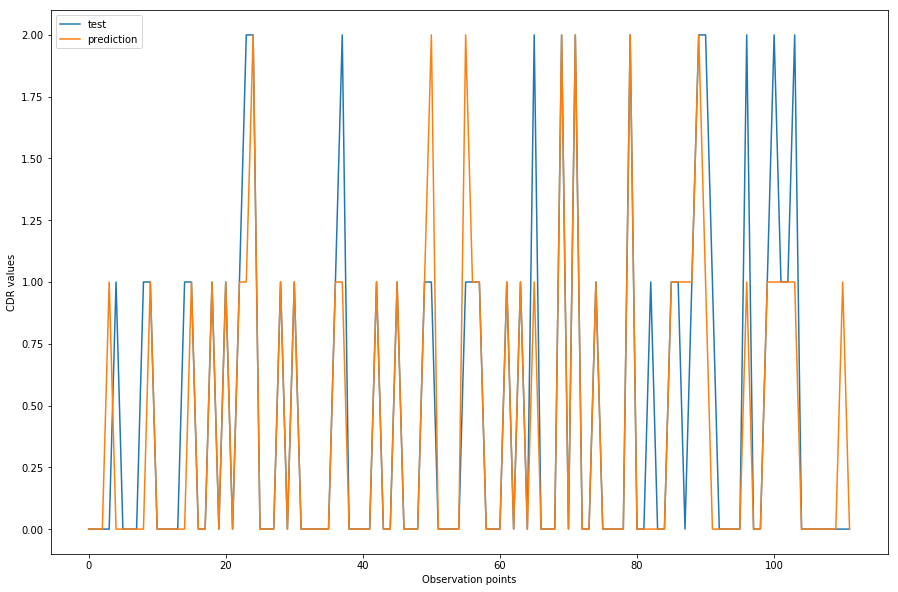

Training score with Decision classifier:  0.946360153256705
Test score with Decision classifier:  0.8839285714285714


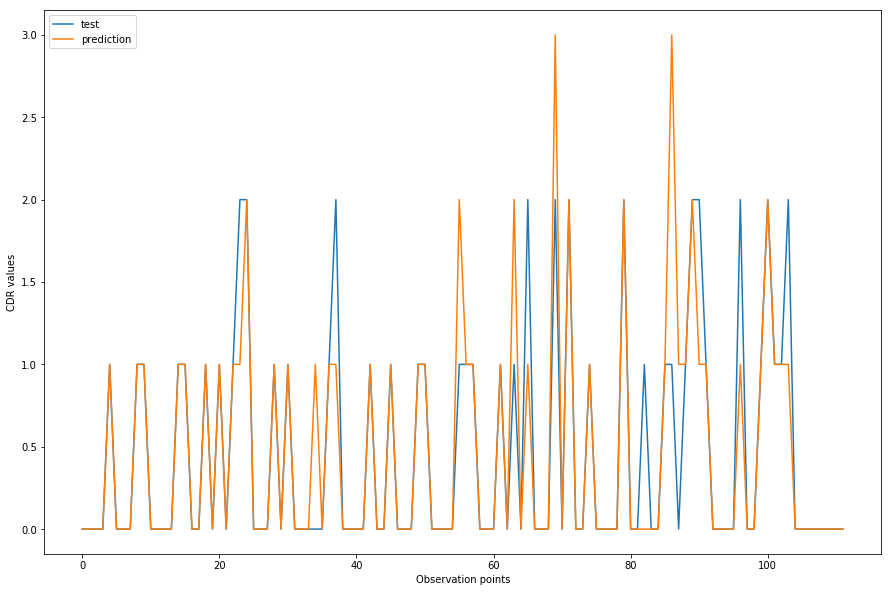

In [14]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train1, y_train1)
prediction = classifier.predict(X_test1)
print("Training score with Logistic regression: ",classifier.score(X_train1, y_train1))
print("Test score with Logistic regression: ",classifier.score(X_test1, y_test1))
plt.plot(a, y_test1)
plt.plot(a, prediction)
plt.xlabel('Observation points')
plt.ylabel('CDR values')
plt.legend(['test', 'prediction'], loc='upper left')
plt.show()
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(max_depth=5)
classifier.fit(X_train1, y_train1)
prediction = classifier.predict(X_test1)
print ("Training score with Decision classifier: ",classifier.score(X_train1, y_train1))
print ("Test score with Decision classifier: ",classifier.score(X_test1, y_test1))
plt.plot(a, y_test1)
plt.plot(a, prediction)
plt.xlabel('Observation points')
plt.ylabel('CDR values')
plt.legend(['test', 'prediction'], loc='upper left')
plt.show()

KNN Training score:  0.89272030651341
KNN Test score:  0.8660714285714286


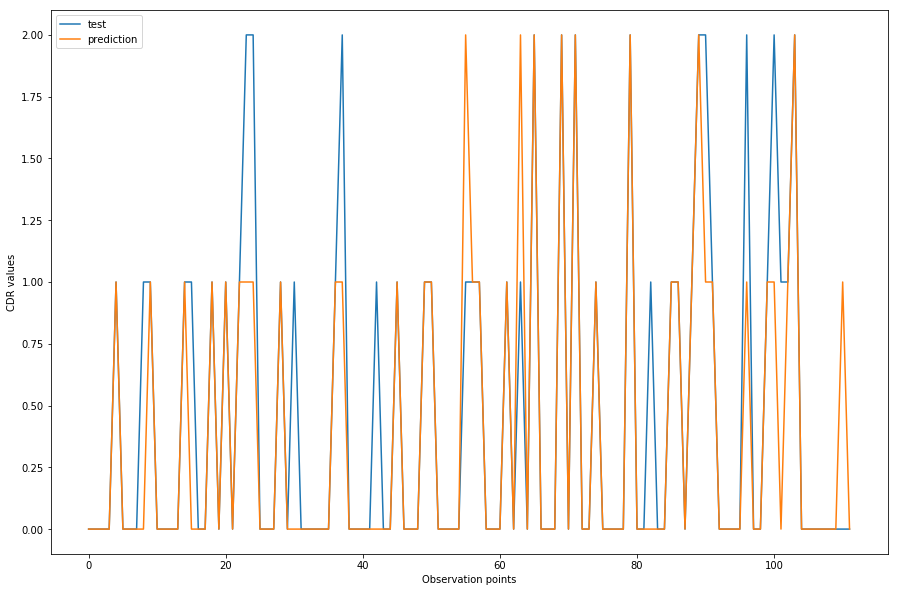

In [15]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train1, y_train1)
print("KNN Training score: ",knn.score(X_train1, y_train1))
prediction = knn.predict(X_test1)
print("KNN Test score: ",knn.score(X_test1, y_test1))
plt.plot(a, y_test1)
plt.plot(a, prediction)
plt.xlabel('Observation points')
plt.ylabel('CDR values')
plt.legend(['test', 'prediction'], loc='upper left')
plt.show()

In [16]:
import tensorflow as tf
from sklearn import metrics
X_FEATURE = 'x' # Name of the input feature.
feature_columns = [
tf.feature_column.numeric_column(
X_FEATURE, shape=np.array(X_train1).shape[1:])]
classifier = tf.estimator.DNNClassifier(feature_columns=feature_columns,
hidden_units=[35,70,35], n_classes=4)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\USER\\AppData\\Local\\Temp\\tmpgvbyf1kq', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000000489937A58>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [17]:
# Train.
train_input_fn = tf.estimator.inputs.numpy_input_fn(x={X_FEATURE: X_train1},
y=y_train1, num_epochs=100, shuffle=False)
cls = classifier.train(input_fn=train_input_fn, steps=1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\USER\AppData\Local\Temp\tmpgvbyf1kq\model.ckpt.
INFO:tensorflow:loss = 203.92032, step = 1
INFO:tensorflow:global_step/sec: 77.0319
INFO:tensorflow:loss = 5.9582887, step = 101 (1.302 sec)
INFO:tensorflow:global_step/sec: 113.878
INFO:tensorflow:loss = 1.3385139, step = 201 (0.879 sec)
INFO:tensorflow:Saving checkpoints for 204 into C:\Users\USER\AppData\Local\Temp\tmpgvbyf1kq\model.ckpt.
INFO:tensorflow:Loss for final step: 0.9563467.


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\USER\AppData\Local\Temp\tmpgvbyf1kq\model.ckpt-204
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


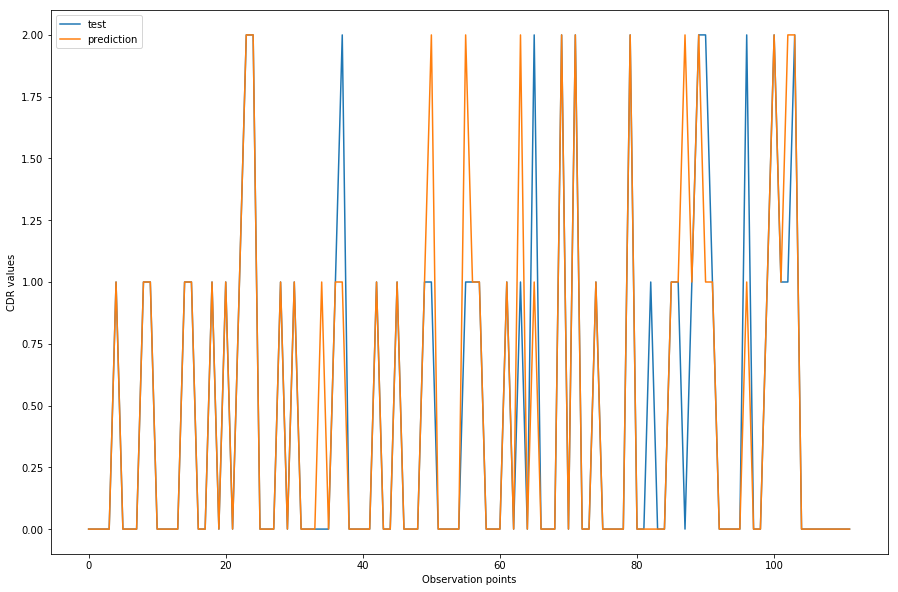

In [18]:
# Predict.
test_input_fn = tf.estimator.inputs.numpy_input_fn(x={X_FEATURE: X_test1}, y=y_test1,
num_epochs=1, shuffle=False)
predictions = classifier.predict(input_fn=test_input_fn)
y_predicted = np.array(list(p['class_ids'] for p in predictions))
y_predicted = y_predicted.reshape(np.array(y_test1).shape)
plt.plot(a, y_test1)
plt.plot(a, y_predicted)
plt.xlabel('Observation points')
plt.ylabel('CDR values')
plt.legend(['test', 'prediction'], loc='upper left')
plt.show()

Accuracy (sklearn): 0.901786


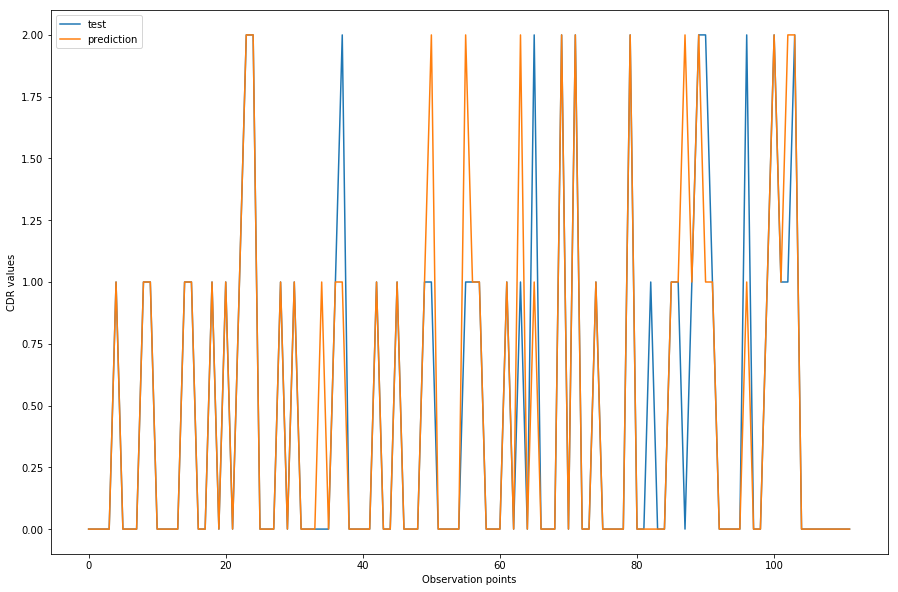

In [19]:
# Score with sklearn.
score = metrics.accuracy_score(y_test1, y_predicted)
print('Accuracy (sklearn): {0:f}'.format(score))
plt.plot(a, y_test1)
plt.plot(a, y_predicted)
plt.xlabel('Observation points')
plt.ylabel('CDR values')
plt.legend(['test', 'prediction'], loc='upper left')
plt.show()

In [20]:
# Score with tensorflow.
scores = classifier.evaluate(input_fn=test_input_fn)
print('Accuracy (tensorflow): {0:f}'.format(scores['accuracy']))


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-03-09-03:39:48
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\USER\AppData\Local\Temp\tmpgvbyf1kq\model.ckpt-204
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-03-09-03:39:50
INFO:tensorflow:Saving dict for global step 204: accuracy = 0.90178573, average_loss = 0.6480133, global_step = 204, loss = 72.57749
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 204: C:\Users\USER\AppData\Local\Temp\tmpgvbyf1kq\model.ckpt-204
Accuracy (tensorflow): 0.901786


In [21]:
import tensorflow as tf
from sklearn import metrics
X_FEATURE = 'x' # Name of the input feature.
feature_columns = [
tf.feature_column.numeric_column(
X_FEATURE, shape=np.array(X_train1).shape[1:])]
classifier = tf.estimator.LinearClassifier(feature_columns=feature_columns, n_classes=4)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\USER\\AppData\\Local\\Temp\\tmpqe6fvs_7', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000000048B05DC18>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [66]:
# Train.
train_input_fn = tf.estimator.inputs.numpy_input_fn(x={X_FEATURE: X_train1},
y=y_train1, num_epochs=100, shuffle=False)
classifier.train(input_fn=train_input_fn, steps=1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\USER\AppData\Local\Temp\tmp8g5yyjjc\model.ckpt.
INFO:tensorflow:loss = 177.44571, step = 1
INFO:tensorflow:global_step/sec: 102.132
INFO:tensorflow:loss = 44.661743, step = 101 (0.998 sec)
INFO:tensorflow:global_step/sec: 80.8958
INFO:tensorflow:loss = 46.84044, step = 201 (1.220 sec)
INFO:tensorflow:Saving checkpoints for 204 into C:\Users\USER\AppData\Local\Temp\tmp8g5yyjjc\model.ckpt.
INFO:tensorflow:Loss for final step: 58.384056.


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\USER\AppData\Local\Temp\tmp8g5yyjjc\model.ckpt-204
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


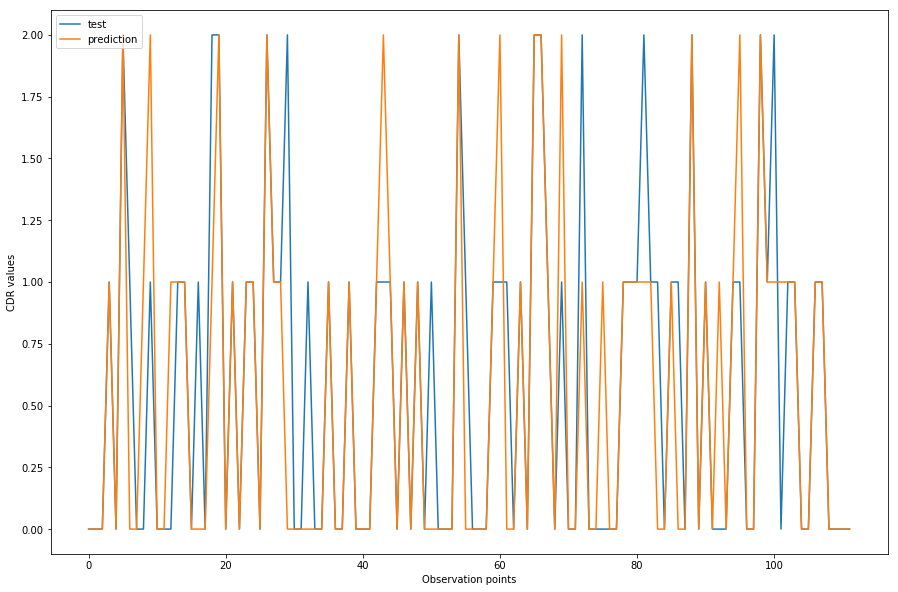

In [68]:
# Predict.
test_input_fn = tf.estimator.inputs.numpy_input_fn(x={X_FEATURE: X_test1}, y=y_test1,
num_epochs=1, shuffle=False)
predictions = classifier.predict(input_fn=test_input_fn)
y_predicted = np.array(list(p['class_ids'] for p in predictions))
y_predicted = y_predicted.reshape(np.array(y_test1).shape)
plt.plot(a, y_test1)
plt.plot(a, y_predicted)
plt.xlabel('Observation points')
plt.ylabel('CDR values')
plt.legend(['test', 'prediction'], loc='upper left')
plt.show()

In [69]:
# Score with sklearn.
score = metrics.accuracy_score(y_test1, y_predicted)
print('Accuracy (sklearn): {0:f}'.format(score))

Accuracy (sklearn): 0.794643


In [70]:
# Score with tensorflow.
scores = classifier.evaluate(input_fn=test_input_fn)
print('Accuracy (tensorflow): {0:f}'.format(scores['accuracy']))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-03-08-17:55:37
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\USER\AppData\Local\Temp\tmp8g5yyjjc\model.ckpt-204
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-03-08-17:55:39
INFO:tensorflow:Saving dict for global step 204: accuracy = 0.79464287, average_loss = 0.46654263, global_step = 204, loss = 52.252773
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 204: C:\Users\USER\AppData\Local\Temp\tmp8g5yyjjc\model.ckpt-204
Accuracy (tensorflow): 0.794643
